In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import PoissonRegressor

# Project setup
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from src.utils.data_partition import temporal_split
from src.utils.visualization import plot_prediction_interval_map, plot_grid_map
from src.conformal.mapie_per_cell import apply_conformal_mapie_per_cell
from src.utils.transformations import aggregate_by_cell
from src.utils.spatial_processing import predictions_to_grid
from src.evaluation.evaluation_cp import compute_misscoverage_per_cell, compute_interval_width_per_cell

# Load config
with open(os.path.join("..", "config.json"), "r") as f:
    config = json.load(f)

# Parameters
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
grid_size = (config["data_generation"]["rows"], config["data_generation"]["cols"])



In [2]:
# Load data
df = pd.read_csv("../data/examples/poisson_example_40x40.csv")

# Partition
days_per_month = 30
train_days = config["data_partition"]["train_months"] * days_per_month
calib_days = config["data_partition"]["calibration_months"] * days_per_month
test_days = config["data_partition"]["test_months"] * days_per_month

df_train, df_calib, df_test = temporal_split(
    df,
    train_days,
    train_days + calib_days,
    train_days + calib_days + test_days
)

# Features and targets
features = ["timestep", "row", "col"]
target = "count"

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()

# Load pre-trained model
naive_model = joblib.load("../results/models/naive_cell_model.pkl")



In [3]:
# Apply conformal prediction per cell using pre-trained model
print("Applying MAPIE per cell using pre-trained Naive model...")
y_pred, y_min, y_max = apply_conformal_mapie_per_cell(
    X_cal, y_cal, X_test,
    base_estimator=naive_model,
    alpha=0.1,
    method="plus",
    grid_size=grid_size,
    prefit=True
)

Applying MAPIE per cell using pre-trained Naive model...


Processing rows: 100%|██████████| 40/40 [00:02<00:00, 16.50it/s]


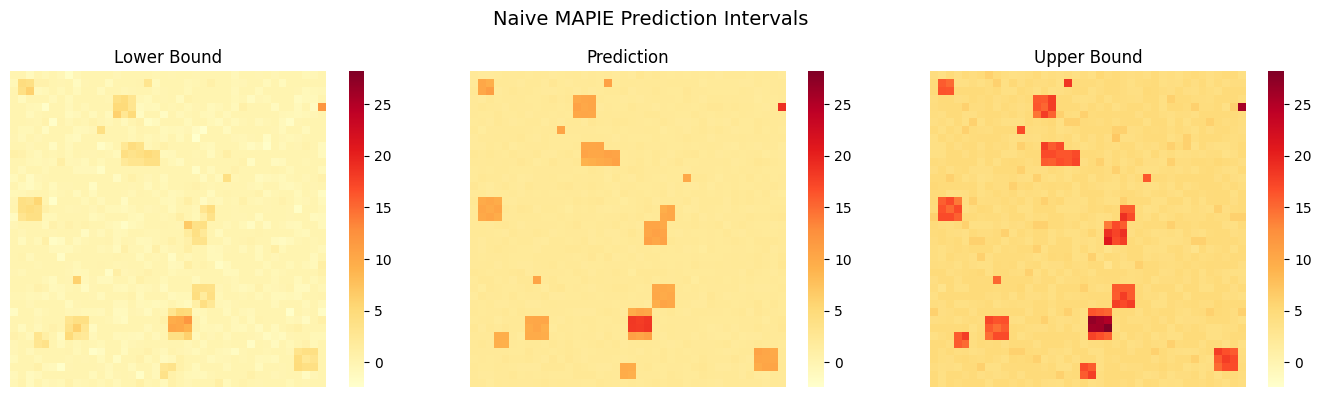

In [4]:
# Asignar predicción directamente
grid_pred = y_pred  # Ya está en formato de grilla (rows x cols)

# Convertir ground truth a grilla
grid_true = aggregate_by_cell(X_test, y_test, grid_size,aggfunc="mean")

# Visualizar intervalos de predicción
plot_prediction_interval_map(
    y_min, grid_pred , y_max,
    title="Naive MAPIE Prediction Intervals",
    titles = [ "Lower Bound","Prediction", "Upper Bound"]
)


In [5]:
grid_true, _ = predictions_to_grid(X_test, y_test, y_test, grid_size, aggregate=False)

In [6]:
misscoverage_grid, overall_misscoverage, std_misscoverage = compute_misscoverage_per_cell(grid_true, y_min, y_max)
width_grid, overall_width, std_width = compute_interval_width_per_cell(y_min, y_max)

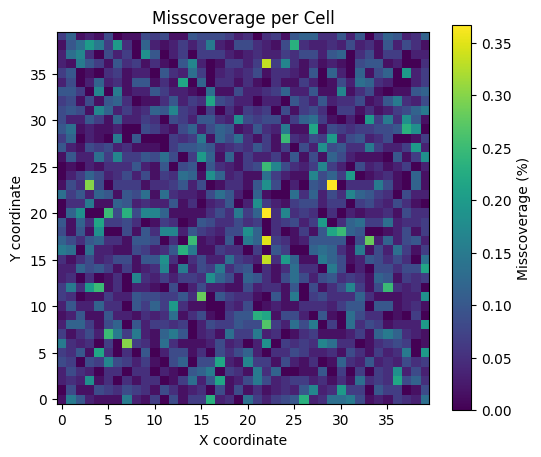

Average Misscoverage: 6.32% ± 24.33%


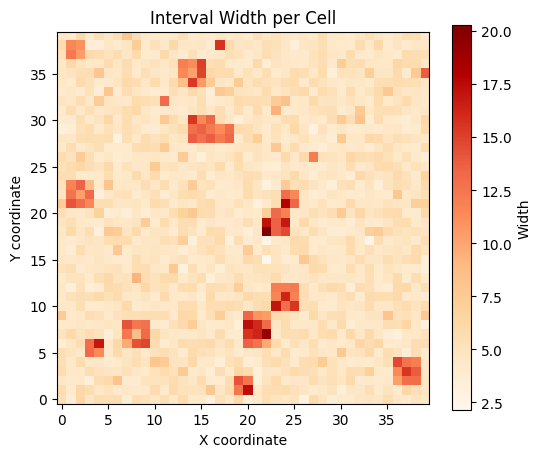

Average interval width: 5.40 ± 2.24


In [7]:
# Visualiza cobertura por celda (Misscoverage)
plot_grid_map(misscoverage_grid, title="Misscoverage per Cell", cmap=None, label="Misscoverage (%)", vmin=0, vmax=misscoverage_grid.max())
print(f"Average Misscoverage: {100 * overall_misscoverage:.2f}% ± {100 * std_misscoverage:.2f}%")

# Visualiza tamaño de intervalo por celda
plot_grid_map(width_grid, title="Interval Width per Cell", cmap="OrRd", label="Width")
print(f"Average interval width: {overall_width:.2f} ± {std_width:.2f}")

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

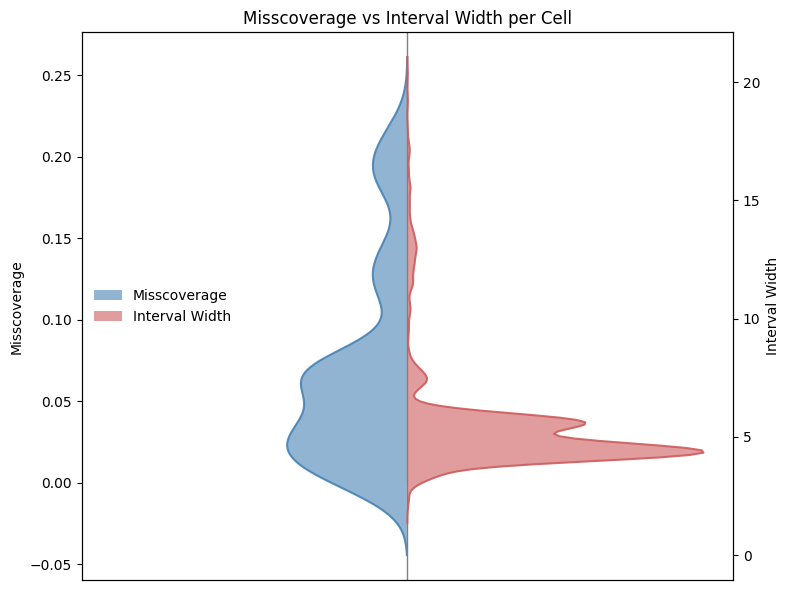

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_split_violin_dual_axis_centered(misscoverage, width_grid, title="Misscoverage vs Interval Width per Cell"):

    interval_width = width_grid.flatten()

    # KDE Misscoverage
    plt.figure()
    sns.kdeplot(misscoverage, bw_adjust=0.5)
    x_miss, y_miss = plt.gca().lines[0].get_data()
    plt.clf()

    # KDE Interval Width
    plt.figure()
    sns.kdeplot(interval_width, bw_adjust=0.5)
    x_width, y_width = plt.gca().lines[0].get_data()
    plt.clf()

    # Crear figura principal
    fig, ax = plt.subplots(figsize=(8, 6))
    ax2 = ax.twinx()

    # Establecer límites simétricos en eje x para centrar
    max_density = max(np.max(y_miss), np.max(y_width)) * 1.1
    ax.set_xlim(-max_density, max_density)

    # Interval Width (derecha)
    ax2.fill_between(y_width, 0, x_width, facecolor="indianred", alpha=0.6, label="Interval Width")
    ax2.plot(y_width, x_width, color="indianred", alpha=0.9)
    ax2.set_ylabel("Interval Width")

    # Misscoverage (izquierda)
    ax.fill_between(-y_miss, 0, x_miss, facecolor="steelblue", alpha=0.6, label="Misscoverage")
    ax.plot(-y_miss, x_miss, color="steelblue", alpha=0.9)
    ax.set_ylabel("Misscoverage")

    # Línea vertical central
    ax.axvline(0, color="gray", linewidth=1)

    # Leyenda combinada
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="center left", frameon=False)

    # Etiquetas generales
    ax.set_xlabel("Density")
    ax.set_title(title)
    ax.axes.get_xaxis().set_visible(False)
    
    plt.tight_layout()
    plt.show()



plot_split_violin_dual_axis_centered(misscoverage_grid, width_grid)

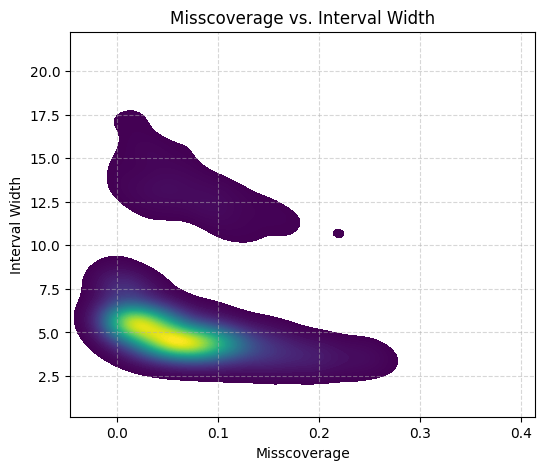

In [9]:
plt.figure(figsize=(6, 5))
sns.kdeplot(
    x=misscoverage_grid.flatten(), 
    y=width_grid.flatten(),
    fill=True, cmap="viridis", thresh=0.03, levels=100
)
plt.xlabel("Misscoverage")
plt.ylabel("Interval Width")
plt.title("Misscoverage vs. Interval Width")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [10]:
from src.utils.spatial_processing import define_hotspot_by_crimes

# Para cada timestep, obtener máscaras
masks_true = []
masks_pred = []

pred_mask = define_hotspot_by_crimes(grid_pred, hotspot_percentage)
for t in range(grid_true.shape[0]):
    true_mask = define_hotspot_by_crimes(grid_true[t], hotspot_percentage)
    masks_true.append(true_mask)
    masks_pred.append(pred_mask)

# Agregar por frecuencia o lógica mayoritaria
gt_hotspot = np.mean(masks_true, axis=0) > 0.3
pred_hotspot = np.sum(masks_pred, axis=0) > 0

# Clasificar celdas
cell_type = np.full(grid_size, "Neither", dtype=object)
cell_type[(gt_hotspot) & (~pred_hotspot)] = "GT-only"
cell_type[(~gt_hotspot) & (pred_hotspot)] = "Pred-only"
cell_type[(gt_hotspot) & (pred_hotspot)] = "Both"

In [11]:
df_metrics = pd.DataFrame({
    "row": np.repeat(np.arange(grid_size[0]), grid_size[1]),
    "col": np.tile(np.arange(grid_size[1]), grid_size[0]),
    "misscoverage": (misscoverage_grid).flatten(),
    "interval_width": width_grid.flatten(),
    "cell_type": cell_type.flatten()
})

C:\Users\capqp\AppData\Local\Temp\ipykernel_3220\1954467044.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_metrics, x="cell_type", y="misscoverage", palette=palette, order=hue_order)


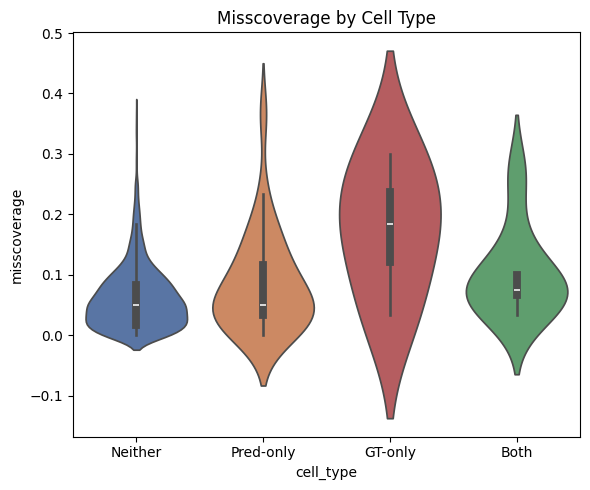

C:\Users\capqp\AppData\Local\Temp\ipykernel_3220\1954467044.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_metrics, x="cell_type", y="interval_width", palette=palette, order=hue_order)


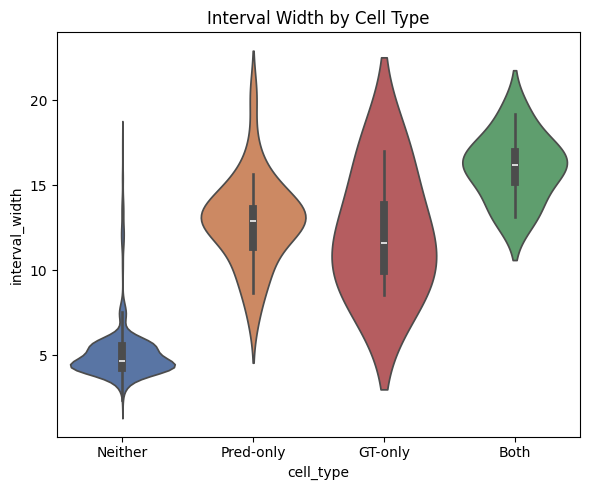

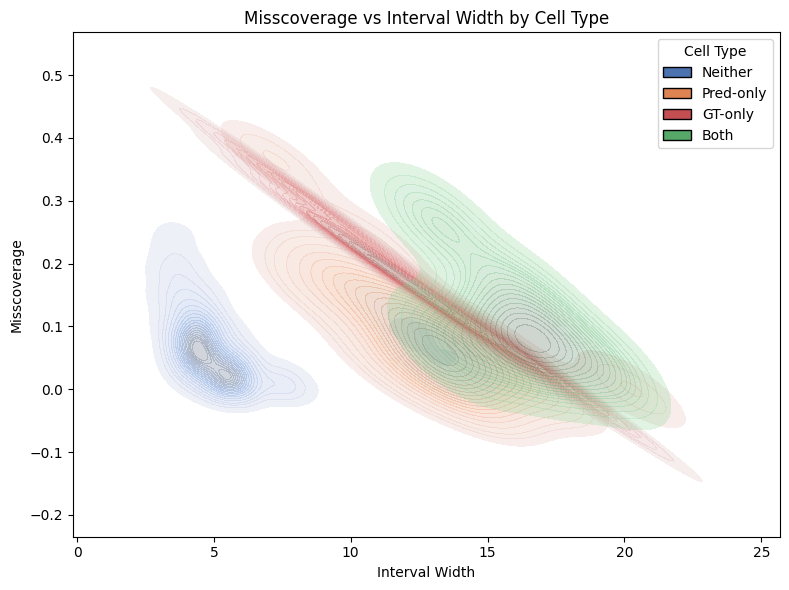

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paleta personalizada
palette = {
    "Neither": "#4c72b0",     # Azul
    "Pred-only": "#dd8452",   # Naranja
    "GT-only": "#c44e52",     # Rojo
    "Both": "#55a868"         # Verde
}

hue_order = ["Neither", "Pred-only", "GT-only", "Both"]

# Gráfico de violines

plt.figure(figsize=(6, 5))
sns.violinplot(data=df_metrics, x="cell_type", y="misscoverage", palette=palette, order=hue_order)
plt.title("Misscoverage by Cell Type")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.violinplot(data=df_metrics, x="cell_type", y="interval_width", palette=palette, order=hue_order)
plt.title("Interval Width by Cell Type")
plt.tight_layout()
plt.show()

# Gráfico KDE bivariado superpuesto
from matplotlib.patches import Patch

plt.figure(figsize=(8, 6))

# Dibujar los KDEs por tipo de celda
for cell_type in hue_order:
    subset = df_metrics[df_metrics["cell_type"] == cell_type]
    sns.kdeplot(
        data=subset,
        x="interval_width",
        y="misscoverage",
        fill=True,
        thresh=0.05,
        levels=20,
        alpha=0.25,
        color=palette[cell_type]
    )

# Crear leyenda manual con colores consistentes
legend_patches = [
    Patch(facecolor=palette[label], edgecolor='black', label=label)
    for label in hue_order
]

plt.title("Misscoverage vs Interval Width by Cell Type")
plt.xlabel("Interval Width")
plt.ylabel("Misscoverage")
plt.legend(handles=legend_patches, title="Cell Type", loc="upper right", frameon=True)
plt.tight_layout()
plt.show()



In [13]:
# Celdas "Both" (predicho y real):

# Se ubican en la región de mayor interval width (más de 15 en muchos casos).

# Tienen bajo misscoverage (cercano a cero).

# 👉 Esto indica que el modelo es más confiado y acierta más cuando realmente hay un hotspot y lo predice.

# Buena precisión pero a costa de intervalos anchos (más incertidumbre).

# Celdas "Pred-only" (predijo hotspot pero no era real):

# Intervalos amplios, pero con mayor misscoverage que las “Both”.

# 👉 El modelo tiene dudas cuando predice un hotspot que no existe, lo que podría indicar falsos positivos con alta incertidumbre.

# Celdas "GT-only" (había un hotspot pero no se predijo):

# Similar rango de intervalos que las anteriores, pero con aún más misscoverage.

# 👉 El modelo no está cubriendo bien estas celdas importantes, lo que es un problema para la toma de decisiones en seguridad. Refleja falsos negativos con baja confiabilidad.

# Celdas "Neither":

# Interval width pequeño y misscoverage bajo.

# 👉 Modelo confiado y acertado en zonas sin actividad relevante. Confiabilidad muy alta cuando no se espera crimen.

### 🔍 Métrica de Confianza para Hotspots

Cuando el modelo predice una celda como hotspot, queremos estimar **qué tan confiado está** en esa predicción. Para esto proponemos una métrica que combine dos factores clave:

1. **Misscoverage (1 - cobertura):** mide cuántas veces el valor real *no* cayó dentro del intervalo predicho.
   - Si la celda tiene alta cobertura, el modelo ha sido preciso allí en el pasado.
   - Usamos su complemento (misscoverage) como indicador de error.

2. **Tamaño del intervalo (interval width):** representa la incertidumbre del modelo.
   - Intervalos grandes indican alta incertidumbre.
   - Se normaliza entre 0 y 1 para que sea comparable.

---

#### 📐 Fórmula propuesta:

Confianza(r,c) = 1 - Misscoverage(r,c) - λ * NormalizedIntervalWidth(r,c)


Donde:
- `Misscoverage(r,c)` es 1 menos la cobertura en la celda `(r,c)`
- `NormalizedIntervalWidth(r,c)` es el ancho del intervalo normalizado entre su mínimo y máximo valor
- `λ` (lambda) es un peso entre 0 y 1 que controla la importancia relativa del tamaño del intervalo

El resultado final se encuentra en el rango `[0, 1]`, donde valores cercanos a 1 indican **alta confianza** en la predicción de hotspot.

---

#### 🧠 Interpretación:

- **Alta confianza (~1):** la celda suele tener buena cobertura y baja incertidumbre.
- **Baja confianza (~0):** el modelo falla frecuentemente o predice con alta incertidumbre.

Esta métrica permite **priorizar acciones** sobre los hotspots con mayor respaldo estadístico.


In [14]:
def compute_hotspot_confidence(misscoverage_grid, width_grid, lambda_param=0.5):
    width_min = np.min(width_grid)
    width_max = np.max(width_grid)
    width_norm = (width_grid - width_min) / (width_max - width_min)

    # confidence = 1 - misscoverage_grid - lambda_param * width_norm
    confidence = 1 - (misscoverage_grid * width_norm)
    confidence = np.clip(confidence, 0, 1)  # asegurar que esté en [0, 1]

    return confidence

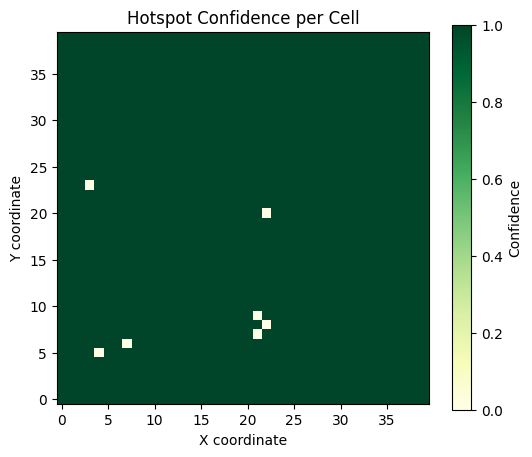

In [26]:
confidence_grid = compute_hotspot_confidence(misscoverage_grid, width_grid, lambda_param=0.5)
plot_grid_map(confidence_grid>0.9, title="Hotspot Confidence per Cell", cmap="YlGn", label="Confidence", vmin=0, vmax=1)


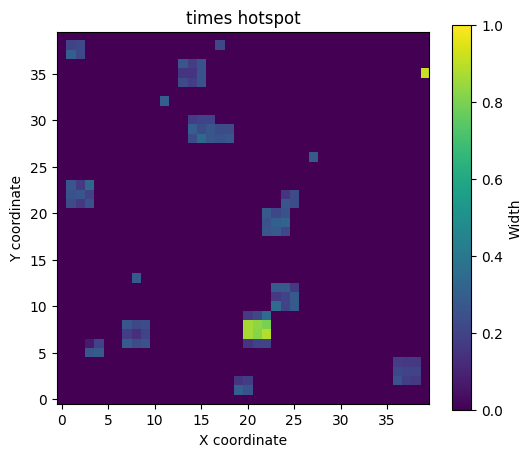

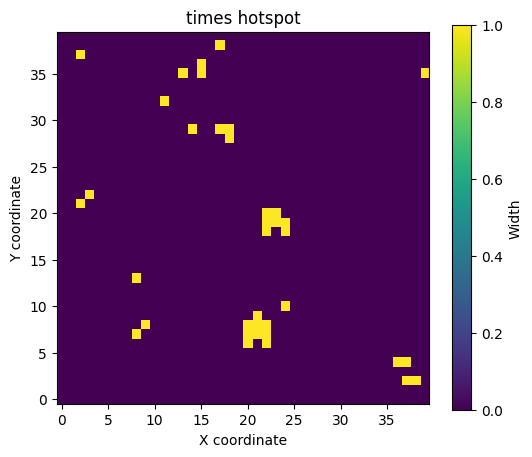

In [27]:
plot_grid_map(np.mean(masks_true, axis=0), title="times hotspot", cmap=None, label="Width",vmax=1)
plot_grid_map(np.mean(masks_pred, axis=0), title="times hotspot", cmap=None, label="Width")

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def classify_cells(freq_grid, conf_grid, freq_thresh=0.25, conf_thresh=0.75):
    """
    Clasifica celdas según frecuencia y confianza.
    
    Parámetros:
    - freq_grid: grid con frecuencia normalizada (0 a 1)
    - conf_grid: grid de confianza (0 a 1)
    - freq_thresh: umbral para considerar "alta frecuencia"
    - conf_thresh: umbral para considerar "alta confianza"

    Devuelve:
    - grid_categoría: matriz con códigos categóricos
    - legenda: diccionario con códigos y significado
    """
    category_grid = np.zeros_like(freq_grid)

    high_freq = freq_grid >= freq_thresh
    high_conf = conf_grid >= conf_thresh

    category_grid[np.where(high_freq & high_conf)] = 0  # Prioritario
    category_grid[np.where(high_freq & ~high_conf)] = 1  # Crítico
    category_grid[np.where(~high_freq & ~high_conf)] = 2  # Vigilancia
    category_grid[np.where(~high_freq & high_conf)] = 3  # Bajo interés

    legend = {
        0: "Prioritario (frecuente, alta confianza)",
        1: "Crítico (frecuente, baja confianza)",
        2: "Vigilancia (poco frecuente, alta confianza)",
        3: "Bajo interés (poco frecuente, alta confianza)"
    }

    return category_grid, legend


In [29]:
import matplotlib.colors as mcolors

def plot_category_grid(category_grid, legend, title="Hotspot Priority Map"):
    
    colors = ["red", "orange", "yellow", "green"]  # del más prioritario al menos
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(category_grid, cmap=cmap, norm=norm, origin="lower")

    cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5],shrink=0.5)
    cbar.ax.set_yticklabels([
        "Prioritario (frecuente, alta confianza)",
        "Crítico (frecuente, baja confianza)",
        "Vigilancia (poco frecuente, baja confianza)",
        "Bajo interés (poco frecuente, alta confianza)"
    ])
    cbar.ax.invert_yaxis() 

    ax.set_title(title)
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    plt.tight_layout()
    plt.show()


### 🔍 **Clasificación de Prioridad de Celdas según Frecuencia y Confianza**

| Categoría      | Frecuencia | Confianza | Color     | Interpretación                                                        |
|----------------|------------|-----------|-----------|------------------------------------------------------------------------|
| 🟥 Prioritario | Alta       | Alta      | Rojo      | Zona activa y el modelo está seguro → alta prioridad de intervención. |
| 🟧 Crítico     | Alta       | Baja      | Naranja   | Zona activa pero incierta → posible error o foco cambiante.           |
| 🟨 Vigilancia  | Baja       | Baja      | Amarillo  | Zona inactiva pero incierta → monitoreo por posible reactivación.     |
| 🟩 Bajo interés| Baja       | Alta      | Verde     | Zona tranquila y con alta confianza → no requiere atención.           |


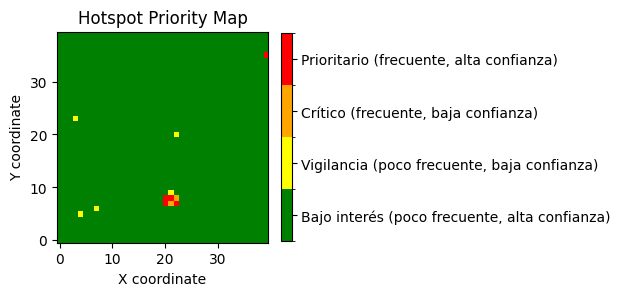

In [31]:
# freq_grid: frecuencia normalizada de hotspots (0-1)
# conf_grid: confianza calculada (0-1)

priority_grid, legend = classify_cells(np.mean(masks_true, axis=0), confidence_grid, freq_thresh=0.5, conf_thresh=0.9)
plot_category_grid(priority_grid, legend)
